In [1]:
import pandas as pd
import numpy as np
import random
# from transformers import ResNetModel
from torch import nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize

In [2]:
base_path = 'archive/'
img_path = f'{base_path}Images/'
cap_path = f'{base_path}captions.txt'
data = pd.read_csv(cap_path)
data.head(n=10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [3]:
item = data.sample(1)
item.image
item = item.reset_index(drop=True)
item.image[0], item.caption[0]

('2705947033_5999147842.jpg', 'Three boys play with toy guns .')

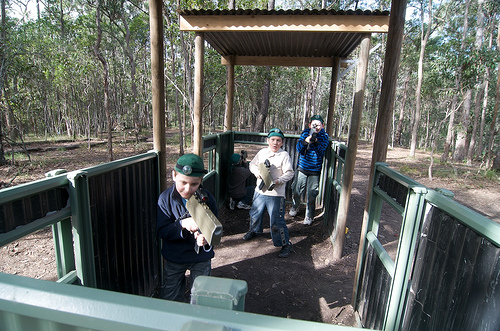

In [4]:
img = Image.open(f'{img_path}{item.image[0]}').convert('RGB')
img

In [5]:
partitions = np.load('flickr8k_partitions.npy', allow_pickle=True).item()

In [6]:
chars = ['<SOS>', '<EOS>', '<PAD>', ' ', '!', '"', '#', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
NUM_CHAR = len(chars)
idx2char = {k: v for k, v in enumerate(chars)}
char2idx = {v: k for k, v in enumerate(chars)}

In [7]:
TEXT_MAX_LEN = 201
DEVICE = 'cuda'

In [8]:
class Data(Dataset):
    def __init__(self, data, partition):
        self.data = data
        self.partition = partition
        self.num_captions = 5
        self.max_len = TEXT_MAX_LEN
        self.img_proc = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.ToTensor(),
            # transforms.Resize((224, 224), antialias=True),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

    def __len__(self):
        return len(self.partition)
    
    def __getitem__(self, idx):
        real_idx = self.num_captions*self.partition[idx]
        item = self.data.iloc[real_idx: real_idx+self.num_captions]
        ## image processing
        img_name = item.image.reset_index(drop=True)[0]
        img = Image.open(f'{img_path}{img_name}').convert('RGB')
        img = self.img_proc(img)
    
        ## caption processing
        caption = item.caption.reset_index(drop=True)[random.choice(list(range(self.num_captions)))]
        cap_list = list(caption)
        final_list = [chars[0]]
        final_list.extend(cap_list)
        final_list.extend([chars[1]])
        gap = self.max_len - len(final_list)
        final_list.extend([chars[2]]*gap)
        cap_idx = [char2idx[i] for i in final_list]
        return img, cap_idx

# Statistics on characters

In [9]:
trainDataset = Data(data, partitions['train'])
valDataset = Data(data, partitions['valid'])
testDataset = Data(data, partitions['test'])

captions_stats = {
    'train':{},
    'validation':{},
    'test':{}
}

In [10]:
print(len(trainDataset), len(valDataset), len(testDataset))

5663 809 1619


In [11]:
max_len = [0, None]
min_len = [1000, None]
train_all_len = []
train_idx_counter = {idx:0 for idx, c in enumerate(chars) if idx != 3}

for i in range(len(trainDataset)):
    image, caption = trainDataset[i]
    
    for char in [0, 1, 2]:
        caption = [idx for idx in caption if idx != char] # ignore pad index
        
    for idx in caption:
        if idx != 3:
            train_idx_counter[idx] += 1 
        
    length = len(caption)
    
    if length >= max_len[0]:
        max_len[0] = len(caption)
        max_len[1] = caption
    if length <= min_len[0]:
        min_len[0] = len(caption)
        min_len[1] = caption
    
    train_all_len.append(length)

captions_stats['train']['max_len'] = (max_len[0], [ idx2char[idx] for idx in max_len[1] ])
captions_stats['train']['min_len'] = (min_len[0], [ idx2char[idx] for idx in min_len[1] ])
captions_stats['train']['avg_len'] = sum(train_all_len)/len(train_all_len)
captions_stats['train']['most_frequent_char'] = (idx2char[max(train_idx_counter, key=train_idx_counter.get)],
                                                 train_idx_counter[max(train_idx_counter, key=train_idx_counter.get)])

In [12]:
max_len = [0, None]
min_len = [1000, None]
val_all_len = []
val_idx_counter = {idx:0 for idx, c in enumerate(chars) if idx != 3}

for i in range(len(valDataset)):
    image, caption = valDataset[i]
    
    for char in [0, 1, 2]:
        caption = [idx for idx in caption if idx != char] # ignore pad index
        
    for idx in caption:
        if idx != 3:
            val_idx_counter[idx] += 1 
        
    length = len(caption)
    
    if length > max_len[0]:
        max_len[0] = len(caption)
        max_len[1] = caption
    if length < min_len[0]:
        min_len[0] = len(caption)
        min_len[1] = caption
    
    val_all_len.append(length)

captions_stats['validation']['max_len'] = (max_len[0], [ idx2char[idx] for idx in max_len[1] ])
captions_stats['validation']['min_len'] = (min_len[0], [ idx2char[idx] for idx in min_len[1] ])
captions_stats['validation']['avg_len'] = sum(val_all_len)/len(val_all_len)
captions_stats['validation']['most_frequent_char'] = (idx2char[max(val_idx_counter, key=val_idx_counter.get)], 
                                                      val_idx_counter[max(val_idx_counter, key=val_idx_counter.get)])

In [13]:
max_len = [0, None]
min_len = [1000, None]
test_all_len = []
test_idx_counter = {idx:0 for idx, c in enumerate(chars) if idx != 3}

for i in range(len(testDataset)):
    image, caption = testDataset[i]
    
    for char in [0, 1, 2]:
        caption = [idx for idx in caption if idx != char] # ignore pad index
        
    for idx in caption:
        if idx != 3:
            test_idx_counter[idx] += 1 
        
    length = len(caption)
    
    if length > max_len[0]:
        max_len[0] = len(caption)
        max_len[1] = caption
    if length < min_len[0]:
        min_len[0] = len(caption)
        min_len[1] = caption
    
    test_all_len.append(length)
    
captions_stats['test']['max_len'] = (max_len[0], [ idx2char[idx] for idx in max_len[1] ])
captions_stats['test']['min_len'] = (min_len[0], [ idx2char[idx] for idx in min_len[1] ])
captions_stats['test']['avg_len'] = sum(test_all_len)/len(test_all_len)
captions_stats['test']['most_frequent_char'] = (idx2char[max(test_idx_counter, key=test_idx_counter.get)], test_idx_counter[max(test_idx_counter, key=test_idx_counter.get)])

In [14]:
print('--------------------------------------')
print('             TRAIN CHARS              ')
print('--------------------------------------')
print(f"One of the longest captions with {captions_stats['train']['max_len'][0]} characters:")
string = ''
for letter in captions_stats['train']['max_len'][1]:
    string += letter
print(string)

print(f"\nOne of the shortest captions with {captions_stats['train']['min_len'][0]} character is:")
string = ''
for letter in captions_stats['train']['min_len'][1]:
    string += letter
print(string)

print(f"\nThe average length of all captions is of {captions_stats['train']['avg_len']} characters.")

print(f"\nThe most frequent character is \'{captions_stats['train']['most_frequent_char'][0]}\' with {captions_stats['train']['most_frequent_char'][1]} appearances.")
print(captions_stats['train']['most_frequent_char'])



print('--------------------------------------')
print('             VAL   CHARS              ')
print('--------------------------------------')
print(f"One of the longest caption with {captions_stats['validation']['max_len'][0]} characters:")
string = ''
for letter in captions_stats['validation']['max_len'][1]:
    string += letter
print(string)

print(f"\nOne of the shortest caption with {captions_stats['validation']['min_len'][0]}:")
string = ''
for letter in captions_stats['validation']['min_len'][1]:
    string += letter
print(string)

print(f"\nThe average length of all captions is of {captions_stats['validation']['avg_len']} characters.")

print(f"\nThe most frequent character is \'{captions_stats['validation']['most_frequent_char'][0]}\' with {captions_stats['validation']['most_frequent_char'][1]} appearances.")
print(captions_stats['validation']['most_frequent_char'])



print('--------------------------------------')
print('             TEST  CHARS              ')
print('--------------------------------------')
print(f"One of the longest caption with {captions_stats['test']['max_len'][0]} characters:")
string = ''
for letter in captions_stats['test']['max_len'][1]:
    string += letter
print(string)

print(f"\nOne of the shortest caption with {captions_stats['test']['min_len'][0]}:")
string = ''
for letter in captions_stats['test']['min_len'][1]:
    string += letter
print(string)

print(f"\nThe average length of all captions is of {captions_stats['test']['avg_len']} characters.")

print(f"\nThe most frequent character is \'{captions_stats['test']['most_frequent_char'][0]}\' with {captions_stats['test']['most_frequent_char'][1]} appearances.")
print(captions_stats['test']['most_frequent_char'])

--------------------------------------
             TRAIN CHARS              
--------------------------------------
One of the longest captions with 173 characters:
A dark haired woman wearing a brown jacket and fatigue bottoms and a balding man wearing a green sweater and blue jeans with a fishing pole , stand at the foot of the surf .

One of the shortest captions with 1 character is:
A

The average length of all captions is of 54.98251809994702 characters.

The most frequent character is 'a' with 23361 appearances.
('a', 23361)
--------------------------------------
             VAL   CHARS              
--------------------------------------
One of the longest caption with 154 characters:
Group of people on a ball team wearing blue and white uniforms some of gloves on their hands one is wearing red shoes , tall trees are in the background .

One of the shortest caption with 15:
a boy screams .

The average length of all captions is of 55.11742892459827 characters.

The most freque

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalize frequencies using MinMaxScaler
scaler = MinMaxScaler()

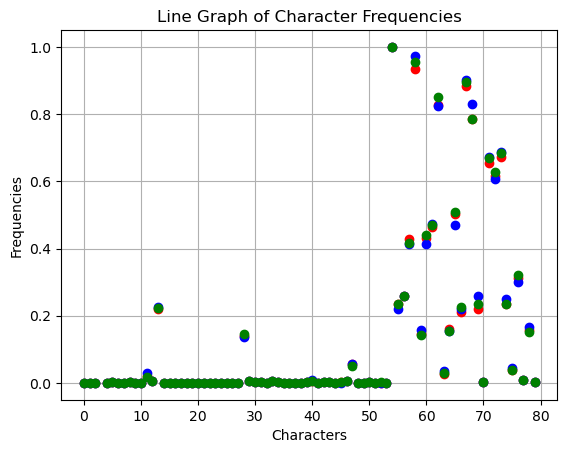

In [16]:
# Extract keys and values from the dictionary
characters1 = list(train_idx_counter.keys())
frequencies1 = scaler.fit_transform([[freq] for freq in list(train_idx_counter.values())]).flatten()

characters2 = list(val_idx_counter.keys())
frequencies2 = scaler.fit_transform([[freq] for freq in list(val_idx_counter.values())]).flatten()

characters3 = list(test_idx_counter.keys())
frequencies3 = scaler.fit_transform([[freq] for freq in list(test_idx_counter.values())]).flatten()

plt.close()
plt.plot(characters1, frequencies1, marker='o', linestyle='', color='r')
plt.plot(characters2, frequencies2, marker='o', linestyle='', color='b')
plt.plot(characters3, frequencies3, marker='o', linestyle='', color='g')
plt.xlabel('Characters')
plt.ylabel('Frequencies')
plt.title('Line Graph of Character Frequencies')
plt.grid(True)
plt.show()

# Statistics on words

In [17]:
TEXT_MAX_LEN = 50

In [18]:
class Vocabulary:
    def __init__(self, freq_threshold: int):
        # Defining some needed tokens for Resnet model
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        # Reversed ITOS dict
        self.stoi = {k:v for v,k in self.itos.items() }
        # Frequency threshold indicator, leading to ignore
        self.freq_threshold = freq_threshold  
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def vocab_tokenizer(text: str):
        return [token.lower() for token in word_tokenize(text)]
    
    def build_vocabulary(self, captions):
        frequencies = {}
        # Start idx 4 because of previous itos tokens
        idx = 4
        for caption in captions:
            for word in self.vocab_tokenizer(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1  
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1      
                    
    def to_one_hot(self, text: str):
        tokenized_text = self.vocab_tokenizer(text)
        return [self.stoi[word] if word in self.stoi else self.stoi['<UNK>'] for word in tokenized_text]

In [19]:
class Data4Words(Dataset):
    def __init__(self, data, partition):
        self.data = data
        self.partition = partition
        self.num_captions = 5
        self.max_len = TEXT_MAX_LEN
        self.img_proc = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.ToTensor(),
            # transforms.Resize((224, 224), antialias=True),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
        self.captions = []

    def __len__(self):
        return len(self.partition)
    
    def __getitem__(self, idx):
        real_idx = self.num_captions*self.partition[idx]
        item = self.data.iloc[real_idx: real_idx+self.num_captions]
        ## image processing
        img_name = item.image.reset_index(drop=True)[0]
        img = Image.open(f'{img_path}{img_name}').convert('RGB')
        img = self.img_proc(img)
    
        ## caption processing
        caption = item.caption.reset_index(drop=True)[random.choice(list(range(self.num_captions)))]
        self.captions.append(caption)
        final_list.extend([chars[2]]*gap)
        cap_idx = [char2idx[i] for i in final_list]
        return img, cap_idx

In [20]:
cap_path = 'archive/captions.txt'
train_captions = []
test_captions = []
valid_captions = []

with open(cap_path, 'r') as file:
    all_data = [word.split(',')[1].lower() for word in file.readlines()]
    for _ in ['train', 'valid', 'test']:
        for idx in partitions[_]:
            real_idx = 5*idx
            all_captions = list(range(real_idx, real_idx+5))
            if _ == 'train':
                for cap_idx in all_captions:
                    train_captions.append(all_data[cap_idx])
            elif _ == 'test':
                for cap_idx in all_captions:
                    test_captions.append(all_data[cap_idx])
            elif _ == 'valid':
                for cap_idx in all_captions:
                    valid_captions.append(all_data[cap_idx])

In [21]:
train_vocab = Vocabulary(freq_threshold=1)
train_vocab.build_vocabulary(train_captions)

val_vocab = Vocabulary(freq_threshold=1)
val_vocab.build_vocabulary(valid_captions)

test_vocab = Vocabulary(freq_threshold=1)
test_vocab.build_vocabulary(test_captions)

In [22]:
print(len(train_vocab))

print(len(test_vocab))

print(len(val_vocab))

7413
4265
2997


In [23]:
captions_stats = {
    'train':{},
    'validation':{},
    'test':{}
}

print(train_vocab.itos)

{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'three', 5: 'men', 6: 'in', 7: 'orange', 8: 'vests', 9: 'are', 10: 'pulling', 11: 'a', 12: 'jeep', 13: 'out', 14: 'of', 15: 'ravine', 16: 'while', 17: 'another', 18: 'man', 19: 'sits', 20: 'inside', 21: '.', 22: 'brown', 23: 'dog', 24: 'runs', 25: 'through', 26: 'the', 27: 'grass', 28: 'holding', 29: 'something', 30: 'its', 31: 'mouth', 32: 'with', 33: 'toy', 34: '``', 35: 'small', 36: 'field', 37: 'chocolate', 38: 'running', 39: 'on', 40: 'white', 41: 'shirt', 42: 'flipping', 43: 'young', 44: 'boy', 45: 'water', 46: 'four', 47: 'other', 48: 'boys', 49: 'surrounding', 50: 'them', 51: 'little', 52: 'girl', 53: 'blue', 54: 'and', 55: 'pink', 56: 'leotard', 57: 'is', 58: 'walking', 59: 'along', 60: 'beam', 61: 'whilst', 62: 'person', 63: "'s", 64: 'hand', 65: 'stretched', 66: 'to', 67: 'support', 68: 'her', 69: 'outfit', 70: 'balance', 71: 'aid', 72: 'woman', 73: 'standing', 74: 'left', 75: 'down', 76: 'an', 77: 'adult', 78: 'ready', 79:

In [24]:
max_len = [0, None]
min_len = [200, None]
train_all_len = []
train_idx_counter = {idx:0 for idx, w in train_vocab.itos.items()}

for i in range(len(trainDataset)):
    _, caption = trainDataset[i]
    
    for _ in [0, 1, 2]:
        caption = [idx for idx in caption if idx != _] # ignore pad index
    
    text = ''
    for letter in caption:
        text += idx2char[letter].lower()
    
    for word in text.split(' '):
        if word not in ['!', ',', '.']:
            try:
                if train_vocab.stoi[word] in train_idx_counter.keys():
                    train_idx_counter[train_vocab.stoi[word]] += 1
            except:
                train_vocab.stoi[word] = len(train_vocab)
                train_vocab.itos[len(train_vocab)] = word
                train_idx_counter[train_vocab.stoi[word]] = 1
    
    length = len(text.split())
    
    if length >= max_len[0]:
        max_len[0] = length
        max_len[1] = text
    if length <= min_len[0]:
        min_len[0] = length
        min_len[1] = text
    
    train_all_len.append(length)

captions_stats['train']['max_len'] = (max_len[0], max_len[1])
captions_stats['train']['min_len'] = (min_len[0], min_len[1])
captions_stats['train']['avg_len'] = sum(train_all_len)/len(train_all_len)
captions_stats['train']['most_frequent_char'] = (train_vocab.itos[max(train_idx_counter, key=train_idx_counter.get)],
                                                 train_idx_counter[max(train_idx_counter, key=train_idx_counter.get)])

In [25]:
max_len = [0, None]
min_len = [200, None]
test_all_len = []
test_idx_counter = {idx:0 for idx, w in test_vocab.itos.items() if idx != 4}

for i in range(len(testDataset)):
    _, caption = testDataset[i]
    
    for _ in [0, 1, 2]:
        caption = [idx for idx in caption if idx != _] # ignore pad index
    
    text = ''
    for letter in caption:
        text += idx2char[letter].lower()
    
    for word in text.split(' '):
        if word not in ['!', ',', '.']:
            try:
                if test_vocab.stoi[word] in test_idx_counter.keys():
                    test_idx_counter[test_vocab.stoi[word]] += 1
            except:
                test_vocab.stoi[word] = len(test_vocab)
                test_vocab.itos[len(test_vocab)] = word
                test_idx_counter[test_vocab.stoi[word]] = 1
    
    length = len(text.split())
    
    if length >= max_len[0]:
        max_len[0] = length
        max_len[1] = text
    if length <= min_len[0]:
        min_len[0] = length
        min_len[1] = text
    
    test_all_len.append(length)

captions_stats['test']['max_len'] = (max_len[0], max_len[1])
captions_stats['test']['min_len'] = (min_len[0], min_len[1])
captions_stats['test']['avg_len'] = sum(test_all_len)/len(test_all_len)
captions_stats['test']['most_frequent_char'] = (test_vocab.itos[max(test_idx_counter, key=test_idx_counter.get)],
                                                 test_idx_counter[max(test_idx_counter, key=test_idx_counter.get)])

In [34]:
max_len = [0, None]
min_len = [200, None]
val_all_len = []
val_idx_counter = {idx:0 for idx, w in val_vocab.itos.items() if idx != 4}

for i in range(len(valDataset)):
    _, caption = valDataset[i]
    
    for _ in [0, 1, 2]:
        caption = [idx for idx in caption if idx != _] # ignore pad index
    
    text = ''
    for letter in caption:
        text += idx2char[letter].lower()
    
    for word in text.split(' '):
        if word not in ['!', ',', '.']:
            try:
                if val_vocab.stoi[word] in val_idx_counter.keys():
                    val_idx_counter[val_vocab.stoi[word]] += 1
            except:
                val_vocab.stoi[word] = len(val_vocab)
                val_vocab.itos[len(val_vocab)] = word
                val_idx_counter[val_vocab.stoi[word]] = 1
    
    length = len(text.split())
    
    if length >= max_len[0]:
        max_len[0] = length
        max_len[1] = text
    if length <= min_len[0]:
        min_len[0] = length
        min_len[1] = text
    
    val_all_len.append(length)

captions_stats['validation']['max_len'] = (max_len[0], max_len[1])
captions_stats['validation']['min_len'] = (min_len[0], min_len[1])
captions_stats['validation']['avg_len'] = sum(val_all_len)/len(val_all_len)
captions_stats['validation']['most_frequent_char'] = (val_vocab.itos[max(val_idx_counter, key=val_idx_counter.get)],
                                                      val_idx_counter[max(val_idx_counter, key=val_idx_counter.get)])

In [35]:
print('--------------------------------------')
print('             TRAIN WORDS              ')
print('--------------------------------------')
print(f"One of the longest captions with {captions_stats['train']['max_len'][0]} words:")
string = ''
for letter in captions_stats['train']['max_len'][1]:
    string += letter
print(string)

print(f"\nOne of the shortest captions with {captions_stats['train']['min_len'][0]} words is:")
string = ''
for letter in captions_stats['train']['min_len'][1]:
    string += letter
print(string)

print(f"\nThe average length of all captions is of {captions_stats['train']['avg_len']} words.")

print(f"\nOne of the most frequent word is \'{captions_stats['train']['most_frequent_char'][0]}\' with {captions_stats['train']['most_frequent_char'][1]} appearances.")
print(captions_stats['train']['most_frequent_char'])



print('--------------------------------------')
print('             TEST  WORDS              ')
print('--------------------------------------')
print(f"One of the longest captions with {captions_stats['test']['max_len'][0]} words:")
string = ''
for letter in captions_stats['test']['max_len'][1]:
    string += letter
print(string)

print(f"\nOne of the shortest captions with {captions_stats['test']['min_len'][0]} words is:")
string = ''
for letter in captions_stats['test']['min_len'][1]:
    string += letter
print(string)

print(f"\nThe average length of all captions is of {captions_stats['test']['avg_len']} words.")

print(f"\nOne of the most frequent word is \'{captions_stats['test']['most_frequent_char'][0]}\' with {captions_stats['test']['most_frequent_char'][1]} appearances.")
print(captions_stats['test']['most_frequent_char'])



print('--------------------------------------')
print('             VAL   WORDS              ')
print('--------------------------------------')
print(f"One of the longest captions with {captions_stats['validation']['max_len'][0]} words:")
string = ''
for letter in captions_stats['validation']['max_len'][1]:
    string += letter
print(string)

print(f"\nOne of the shortest captions with {captions_stats['validation']['min_len'][0]} words is:")
string = ''
for letter in captions_stats['validation']['min_len'][1]:
    string += letter
print(string)

print(f"\nThe average length of all captions is of {captions_stats['validation']['avg_len']} words.")

print(f"\nOne of the most frequent word is \'{captions_stats['validation']['most_frequent_char'][0]}\' with {captions_stats['validation']['most_frequent_char'][1]} appearances.")
print(captions_stats['validation']['most_frequent_char'])

--------------------------------------
             TRAIN WORDS              
--------------------------------------
One of the longest captions with 34 words:
two men are talking on the street ; one is pointing at a sign that says " jesus or hell " beneath a red box , and the other is standing there listening .

One of the shortest captions with 2 words is:
dog yawns

The average length of all captions is of 11.716934487021014 words.

One of the most frequent word is 'a' with 8816 appearances.
('a', 8816)
--------------------------------------
             TEST  WORDS              
--------------------------------------
One of the longest captions with 33 words:
a young child in a t-shirt on a bike stands in on a road in front of a beach , while others are on the sand near the water in the background .

One of the shortest captions with 2 words is:
trucks racing

The average length of all captions is of 11.716491661519456 words.

One of the most frequent word is 'in' with 785 appearan

In [28]:
# Find keys not shared between dict1 and dict2
not_shared_keys_TRAIN_TEST = set(train_vocab.stoi.keys()) ^ set(test_vocab.stoi.keys())
not_shared_keys_TRAIN_VAL = set(train_vocab.stoi.keys()) ^ set(val_vocab.stoi.keys())

# shared = set(train_vocab.stoi.keys()) ^ set(test_vocab.stoi.keys())

print(f"There are {len(not_shared_keys_TRAIN_TEST)} out of {len(train_vocab.stoi)} words that are NOT shared between train and test sets.")
print(f"There are {len(not_shared_keys_TRAIN_VAL)} out of {len(train_vocab.stoi)} words that are NOT shared between train and val sets.")

There are 4926 out of 7478 words that are NOT shared between train and test sets.
There are 5361 out of 7478 words that are NOT shared between train and val sets.


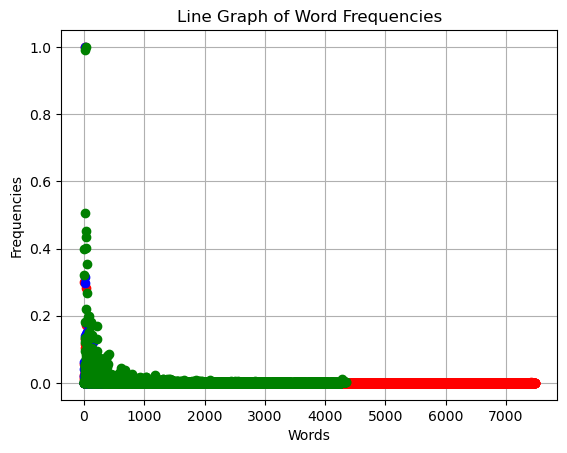

In [29]:
# Extract keys and values from the dictionary
characters1 = list(train_idx_counter.keys())
frequencies1 = scaler.fit_transform([[freq] for freq in list(train_idx_counter.values())]).flatten()

characters2 = list(val_idx_counter.keys())
frequencies2 = scaler.fit_transform([[freq] for freq in list(val_idx_counter.values())]).flatten()

characters3 = list(test_idx_counter.keys())
frequencies3 = scaler.fit_transform([[freq] for freq in list(test_idx_counter.values())]).flatten()

plt.close()
plt.plot(characters1, frequencies1, marker='o', linestyle='', color='r')
plt.plot(characters2, frequencies2, marker='o', linestyle='', color='b')
plt.plot(characters3, frequencies3, marker='o', linestyle='', color='g')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Line Graph of Word Frequencies')
plt.grid(True)
plt.show()

# Images analytics

In [30]:
max_width = 0
max_height = 0
min_width = 500
min_height = 500

train_all_height, train_all_width = [], []

for i in range(len(trainDataset)):
    img, _ = trainDataset[i]
    
    _, height, width = img.shape
    
    if height >= max_height:
        max_height = height
    if width >= max_width:
        max_width = width
    if height <= min_height:
        min_height = height
    if width <= min_width:
        min_width = width
    
    train_all_height.append(height)
    train_all_width.append(width)

captions_stats['train']['max_h'] = max_height
captions_stats['train']['max_w'] = max_width
captions_stats['train']['min_h'] = min_height
captions_stats['train']['min_w'] = min_width
captions_stats['train']['avg_h'] = sum(train_all_height)/len(train_all_height)
captions_stats['train']['avg_w'] = sum(train_all_width)/len(train_all_width)

In [31]:
max_width = 0
max_height = 0
min_width = 500
min_height = 500

val_all_height, val_all_width = [], []

for i in range(len(valDataset)):
    img, _ = valDataset[i]
    
    _, height, width = img.shape
    
    if height >= max_height:
        max_height = height
    if width >= max_width:
        max_width = width
    if height <= min_height:
        min_height = height
    if width <= min_width:
        min_width = width
    
    val_all_height.append(height)
    val_all_width.append(width)

captions_stats['validation']['max_h'] = max_height
captions_stats['validation']['max_w'] = max_width
captions_stats['validation']['min_h'] = min_height
captions_stats['validation']['min_w'] = min_width
captions_stats['validation']['avg_h'] = sum(val_all_height)/len(val_all_height)
captions_stats['validation']['avg_w'] = sum(val_all_width)/len(val_all_width)

In [32]:
max_width = 0
max_height = 0
min_width = 500
min_height = 500

test_all_height, test_all_width = [], []

for i in range(len(testDataset)):
    img, _ = testDataset[i]
    
    _, height, width = img.shape
    
    if height >= max_height:
        max_height = height
    if width >= max_width:
        max_width = width
    if height <= min_height:
        min_height = height
    if width <= min_width:
        min_width = width
    
    test_all_height.append(height)
    test_all_width.append(width)

captions_stats['test']['max_h'] = max_height
captions_stats['test']['max_w'] = max_width
captions_stats['test']['min_h'] = min_height
captions_stats['test']['min_w'] = min_width
captions_stats['test']['avg_h'] = sum(test_all_height)/len(test_all_height)
captions_stats['test']['avg_w'] = sum(test_all_width)/len(test_all_width)

In [33]:
print('--------------------------------------')
print('             TRAIN IMAGES             ')
print('--------------------------------------')
print(f"The maximum height is of {captions_stats['train']['max_h'] } pixels.")
print(f"The minimum height is of {captions_stats['train']['min_h'] } pixels.")
print(f"The average height of all images is of {captions_stats['train']['avg_h']} pixels.")
print(f"\nThe maximum width is of {captions_stats['train']['max_w'] } pixels.")
print(f"The minimum width is of {captions_stats['train']['min_w'] } pixels.")
print(f"The average width of all images is of {captions_stats['train']['avg_w']} pixels.")

print('--------------------------------------')
print('               VAL IMAGES             ')
print('--------------------------------------')
print(f"The maximum height is of {captions_stats['validation']['max_h'] } pixels.")
print(f"The minimum height is of {captions_stats['validation']['min_h'] } pixels.")
print(f"The average height of all images is of {captions_stats['validation']['avg_h']} pixels.")
print(f"\nThe maximum width is of {captions_stats['validation']['max_w'] } pixels.")
print(f"The minimum width is of {captions_stats['validation']['min_w'] } pixels.")
print(f"The average width of all images is of {captions_stats['validation']['avg_w']} pixels.")

print('--------------------------------------')
print('              TEST IMAGES             ')
print('--------------------------------------')
print(f"The maximum height is of {captions_stats['test']['max_h'] } pixels.")
print(f"The minimum height is of {captions_stats['test']['min_h'] } pixels.")
print(f"The average height of all images is of {captions_stats['test']['avg_h']} pixels.")
print(f"\nThe maximum width is of {captions_stats['test']['max_w'] } pixels.")
print(f"The minimum width is of {captions_stats['test']['min_w'] } pixels.")
print(f"The average width of all images is of {captions_stats['test']['avg_w']} pixels.")

--------------------------------------
             TRAIN IMAGES             
--------------------------------------
The maximum height is of 500 pixels.
The minimum height is of 127 pixels.
The average height of all images is of 396.77662016598975 pixels.

The maximum width is of 500 pixels.
The minimum width is of 164 pixels.
The average width of all images is of 458.07752074871973 pixels.
--------------------------------------
               VAL IMAGES             
--------------------------------------
The maximum height is of 500 pixels.
The minimum height is of 176 pixels.
The average height of all images is of 398.39431396786154 pixels.

The maximum width is of 500 pixels.
The minimum width is of 202 pixels.
The average width of all images is of 457.68726823238563 pixels.
--------------------------------------
              TEST IMAGES             
--------------------------------------
The maximum height is of 500 pixels.
The minimum height is of 151 pixels.
The average height 